In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

Computations performed in this notebook may take hours. Therefore, we have implemented notebook extension called `skip_cell` which could be used to omit certain cells. We defined global variables `IMPATIENCE` which should be set to `True` when you want to load data and/or models from disk.

In [2]:
%load_ext skip_cell

In [3]:
IMPATIENCE = True

# Extracting features using CNN

We have started by preprocessing images. We have reshaped them and have performed random crop in order to transform them to target size of `(224, 224, 3)`. Then, we have defined data loaders using [`ImageFoldersDataset`](https://github.com/stasulam/tmle/blob/master/tmle/dataloaders.py#L12).

In [4]:
from torchvision import transforms
from tmle.dataloaders import ImageFoldersDataset

# define transformations
basic_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])
# define dataset
train_dataset = ImageFoldersDataset(
    path_to_data='../data/cpu/train/',
    transform=basic_transforms
)
test_dataset = ImageFoldersDataset(
    path_to_data='../data/cpu/test/',
    transform=basic_transforms
)

(**NOTE**) In order to use `ImageFoldersDataset` images must be organized in the following way:

In [5]:
!tree -d ../data

../data
├── cpu
│   ├── test
│   │   ├── bird
│   │   ├── boat
│   │   ├── cat
│   │   ├── dog
│   │   ├── flower
│   │   ├── frog
│   │   ├── jumbojet
│   │   ├── mushroom
│   │   ├── sportscar
│   │   └── tree
│   └── train
│       ├── bird
│       ├── boat
│       ├── cat
│       ├── dog
│       ├── flower
│       ├── frog
│       ├── jumbojet
│       ├── mushroom
│       ├── sportscar
│       └── tree
└── gpu
    ├── test
    │   ├── bird
    │   ├── boat
    │   ├── cat
    │   ├── dog
    │   ├── flower
    │   ├── frog
    │   ├── jumbojet
    │   ├── mushroom
    │   ├── sportscar
    │   └── tree
    └── train
        ├── bird
        ├── boat
        ├── cat
        ├── dog
        ├── flower
        ├── frog
        ├── jumbojet
        ├── mushroom
        ├── sportscar
        └── tree

46 directories


Then, we have downloaded `ResNet18` with weights obtained from `ImageNet`. `tmle` package provides class [`CNNFeatures`](https://github.com/stasulam/tmle/blob/master/tmle/transformers.py#L12) which implements methods useful in transforming images into feature vectors. We have instantiated `CNNFeatures` with `n_features` set to `512` and `rm_top_layers` set to `1` (which removes fully-connected layer from the top of the network).

In [6]:
from torchvision import models
from tmle.transformers import CNNFeatures

resnet18 = models.resnet18(pretrained=True)
resnet18_features = CNNFeatures(
    n_features=512,
    rm_top_layers=1
)

After fixing weights of our network we have performed forward pass in order to obtain features vectors of sizes `(512, 1)`. We can skip this step and load `np.ndarray` from `../data/` directory.

In [7]:
%%skip $IMPATIENCE
X_resnet18, y_resnet18 = resnet18_features.extract_features(
    model=resnet18,
    dataset=train_dataset
)
X_resnet18_test, y_resnet18_test = resnet18_features.extract_features(
    model=resnet18,
    dataset=test_dataset
)
# save np.ndarrays
np.save('../data/X_resnet18.npy', arr=X_resnet18)
np.save('../data/y_resnet18.npy', arr=y_resnet18)
np.save('../data/X_resnet18_test.npy', arr=X_resnet18_test)
np.save('../data/y_resnet18_test.npy', arr=y_resnet18_test)

We have repeated the same computations for `ResNet50`.

In [8]:
resnet50 = models.resnet50(pretrained=True)
resnet50_features = CNNFeatures(
    n_features=2048,
    rm_top_layers=1
)

In [9]:
%%skip $IMPATIENCE
X_resnet50, y_resnet50 = resnet50_features.extract_features(
    model=resnet50,
    dataset=train_dataset
)
X_resnet50_test, y_resnet50_test = resnet50_features.extract_features(
    model=resnet50,
    dataset=test_dataset
)
# save np.ndarrays
np.save('../data/X_resnet50.npy', arr=X_resnet50)
np.save('../data/y_resnet50.npy', arr=y_resnet50)
np.save('../data/X_resnet50_test.npy', arr=X_resnet50_test)
np.save('../data/y_resnet50_test.npy', arr=y_resnet50_test)

## SVM on top of features from ResNet18

Set `EXPERIMENT_NAME`. Results of experiments will be stored in `../experiments/{EXPERIMENT_NAME}.hpopt` and could be further used both: to continuing search for optimal *hyperparameters* or to training model with best subset of already obtained *hyperparameters* values.

In [10]:
EXPERIMENT_NAME = 'resnet18_svm'

In [11]:
X_resnet18, y_resnet18 = np.load('../data/X_resnet18.npy'), np.load('../data/y_resnet18.npy')

We have tuned `SVM` using [`ClassifierOptimizer`](https://github.com/stasulam/tmle/blob/master/tmle/model_selection.py#L15) from `tmle`. For given set of *hyperparameters* (drawn from space defined below) we measure performance on datasets obtained from performing `StratifiedKFold` (due to imbalanced classes) with `balanced_accuracy_score` (same reason). Because of high dimensionality of data the risk of overfitting was very high. Thus, we implemented additional penalty to prevent `TPE` from sampling *hyperparameters* that leads to overfitting (See: [line 143](https://github.com/stasulam/tmle/blob/master/tmle/model_selection.py#L143)).

During training we optimize following hyperparameters:

* `penalty`: specifies the norm used in the penalization. The $L^{2}$ penalty is the standard used in `SVC`. The $L^{1}$ leads to coefficients vectors that are sparse.
* `class_weight`: if not given, all classes are supposed to have weight one. The *balanced* mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.
* `C`: penalty parameter `C` of the error term.

In [12]:
import hyperopt
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK

space = dict()
space['penalty'] = hp.choice('penalty', ['l1', 'l2'])
space['class_weight'] = hp.choice('class_weight', [None, 'balanced'])
space['C'] = hp.uniform('C', 0.0001, 5)

We fixed certain parameters of `LinearSVC`. `max_iter` was set to 20000 (with default value equals 1000) in order to counteract the problem of convergence. `dual` (which select the algorithm to either solve the dual or primal optimization problem) in order to enable $L^{1}$ penalty.

In [13]:
from tmle.model_selection import ClassifierOptimizer
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score

clf_optim = ClassifierOptimizer(
    classifier=LinearSVC(
        max_iter=20000,
        random_state=42,
        dual=False,
        verbose=1
    ),
    space=space,
    metric=balanced_accuracy_score
)

*Hyperparameters* tuning can take hours. Experiments conducted by me during preparation of this notebook took nearly 24 hours on my MacBook. Therefore, I recommend to load experiments results from disk.

In [14]:
%%skip $IMPATIENCE
import warnings
warnings.filterwarnings("ignore")

clf_optim.find_best_params(
    X_resnet18,
    y_resnet18,
    experiments_path='../experiments/',
    experiments_name=EXPERIMENT_NAME,
    max_evals=10,
    overfit_penalty=0.1
)

Load `hyperopt.Trials` from disk. It stores information about conducted experiments.

In [15]:
import pickle

trials_path = os.path.join('../experiments/', 'resnet18_svm.hpopt')
with open(trials_path, 'rb') as trials:
    trials = pickle.load(trials)

Then, we evaluate experiments by loading sets of *hyperparameters* with corresponding scores achieved on both: training and validation sets (as mean value on all folds). We additionaly introduce `train_valid_diff` measure which is calculated as a difference between scores achieved on train and validation sets.

In [16]:
experiments = clf_optim.evaluate_experiments(trials.trials)\
    .fillna(value='None')\
    .assign(train_valid_diff = lambda x: x.train - x.valid)

We have visualized results.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Scores on train.

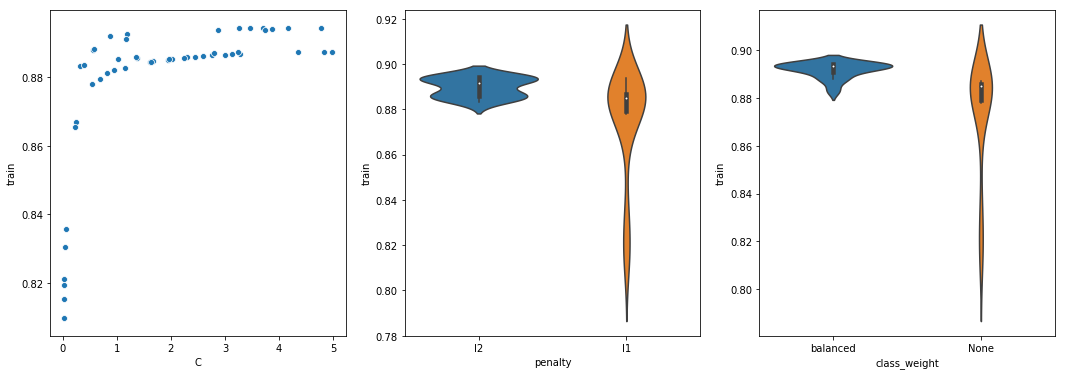

In [18]:
f, ax = plt.subplots(figsize=(18, 6), ncols=3)
sns.scatterplot(x='C', y='train', data=experiments, ax=ax[0])
sns.violinplot(x='penalty', y='train', data=experiments, ax=ax[1])
sns.violinplot(x='class_weight', y='train', data=experiments, ax=ax[2])

Scores on validation.

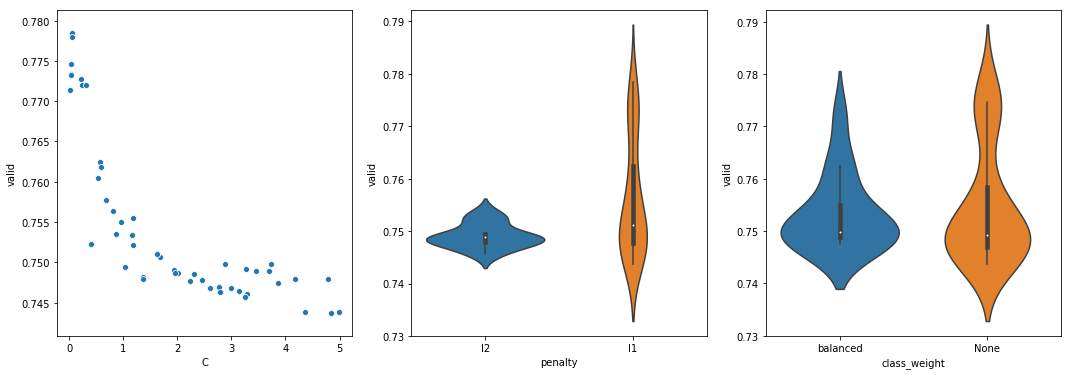

In [19]:
f, ax = plt.subplots(figsize=(18, 6), ncols=3)
sns.scatterplot(x='C', y='valid', data=experiments, ax=ax[0])
sns.violinplot(x='penalty', y='valid', data=experiments, ax=ax[1])
sns.violinplot(x='class_weight', y='valid', data=experiments, ax=ax[2])

Differences between train and validation scores.

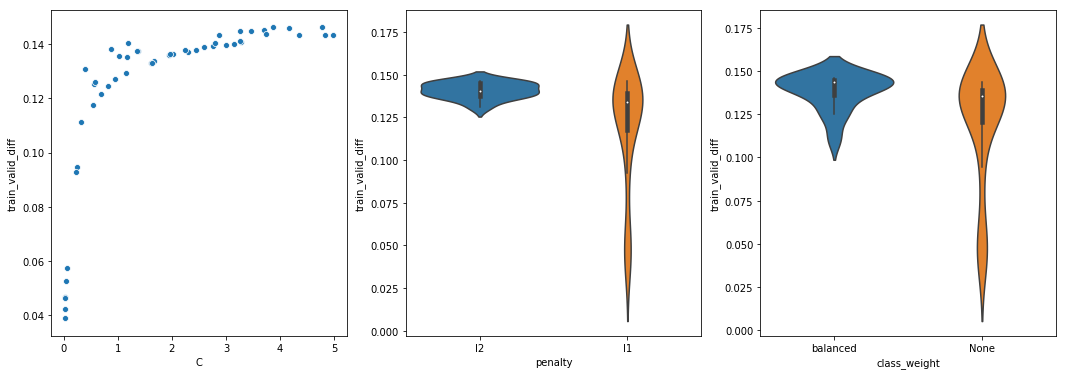

In [20]:
f, ax = plt.subplots(figsize=(18, 6), ncols=3)
sns.scatterplot(x='C', y='train_valid_diff', data=experiments, ax=ax[0])
sns.violinplot(x='penalty', y='train_valid_diff', data=experiments, ax=ax[1])
sns.violinplot(x='class_weight', y='train_valid_diff', data=experiments, ax=ax[2])

Then, we present subset of *hyperparameters* which maximixed the performance of classifier. We should notice that the best results was achieved with relatively high regularization. Value of `C` and selected `penalty` encourages the algorithm to prefer more regularized solutions.

In [21]:
resnet18_best_params = clf_optim.space_eval(trials.best_trial)
resnet18_best_params

{'C': 0.05257098248823999, 'class_weight': None, 'penalty': 'l1'}

In [22]:
%%skip $IMPATIENCE
clf = LinearSVC(
    max_iter=20000,
    random_state=42,
    dual=False,
    verbose=1
).set_params(**resnet18_best_params)
clf.fit(X_resnet18, y_resnet18)
# save model
from joblib import dump
dump(clf, '../models/resnet18_svm.joblib')

Load model from disk.

In [23]:
from joblib import load

clf = load('../models/resnet18_svm.joblib')

Load test set.

In [24]:
X_resnet18_test, y_resnet18_test = np.load('../data/X_resnet18_test.npy'), np.load('../data/y_resnet18_test.npy')

In [25]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

for x_i, y_i in zip([X_resnet18, X_resnet18_test], [y_resnet18, y_resnet18_test]):
    y_pred = clf.predict(x_i)
    print('Accuracy: {acc:.5f}. Balanced accuracy: {bal_acc:.5f}'.format(
        acc=accuracy_score(y_i, y_pred),
        bal_acc=balanced_accuracy_score(y_i, y_pred)
    ))

Accuracy: 0.85285. Balanced accuracy: 0.82905
Accuracy: 0.80200. Balanced accuracy: 0.80200


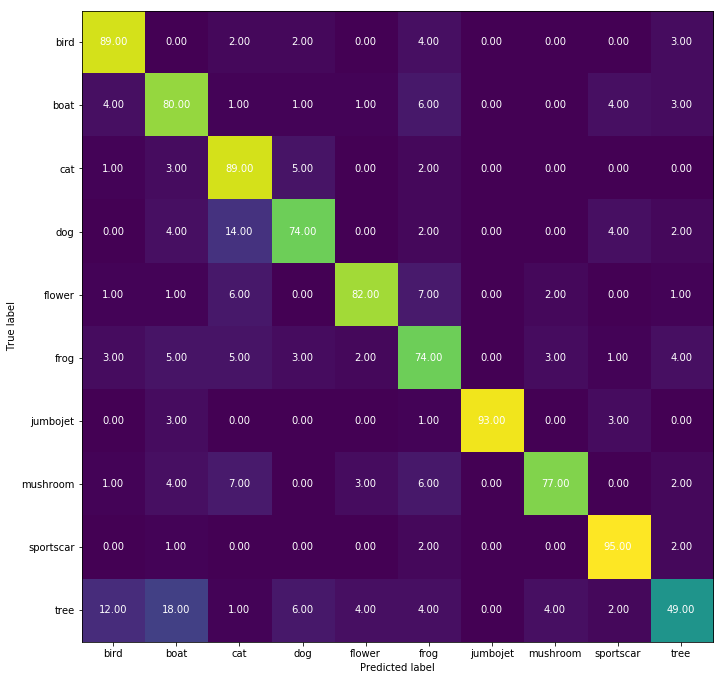

In [26]:
from sklearn.metrics import confusion_matrix
from tmle.visualizations import plot_confusion_matrix

cm_test = confusion_matrix(y_true=y_resnet18_test, y_pred=clf.predict(X_resnet18_test))
plot_confusion_matrix(cm_test)

## SVM on top of features from ResNet50

We have repeated the same experiments for feature vectors obtained with `ResNet50`.

In [27]:
EXPERIMENT_NAME = 'resnet50_svm'

In [28]:
X_resnet50, y_resnet50 = np.load('../data/X_resnet50.npy'), np.load('../data/y_resnet18.npy')

In [29]:
import hyperopt
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK

space = dict()
space['penalty'] = hp.choice('penalty', ['l1', 'l2'])
space['class_weight'] = hp.choice('class_weight', [None, 'balanced'])
space['C'] = hp.uniform('C', 0.0001, 0.1)

In [30]:
from tmle.model_selection import ClassifierOptimizer
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score

clf_optim = ClassifierOptimizer(
    classifier=LinearSVC(
        max_iter=20000,
        random_state=42,
        verbose=1,
        dual=False
    ),
    space=space,
    metric=balanced_accuracy_score
)

In [31]:
%%skip $IMPATIENCE
import warnings
warnings.filterwarnings("ignore")

clf_optim.find_best_params(
    X_resnet50,
    y_resnet50,
    experiments_path='../experiments/',
    experiments_name=EXPERIMENT_NAME,
    max_evals=50,
    overfit_penalty=0.1
)

The high dimensionality of the data makes it practically impossible to carry out a reasonable number of experiments in a limited period of time. Therefore, we decided to fit classifier with best subset of parameters obtained during experiments which were made on features from `ResNet18`.

In [32]:
%%skip $IMPATIENCE
clf = LinearSVC(
    max_iter=20000,
    random_state=42,
    dual=False,
    verbose=1
).set_params(**resnet18_best_params)
clf.fit(X_resnet50, y_resnet50)
# save model
from joblib import dump
dump(clf, '../models/resnet50_svm.joblib')

Load classifier from disk.

In [33]:
from joblib import load

clf = load('../models/resnet50_svm.joblib')

Load test set.

In [34]:
X_resnet50_test, y_resnet50_test = np.load('../data/X_resnet50_test.npy'), np.load('../data/y_resnet50_test.npy')

We have observed that `SVM` built on top of `ResNet50` performed slightly better.

In [35]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

for x_i, y_i in zip([X_resnet50, X_resnet50_test], [y_resnet50, y_resnet50_test]):
    y_pred = clf.predict(x_i)
    print('Accuracy: {acc:.5f}. Balanced accuracy: {bal_acc:.5f}'.format(
        acc=accuracy_score(y_i, y_pred),
        bal_acc=balanced_accuracy_score(y_i, y_pred)
    ))

Accuracy: 0.88401. Balanced accuracy: 0.86142
Accuracy: 0.84500. Balanced accuracy: 0.84500


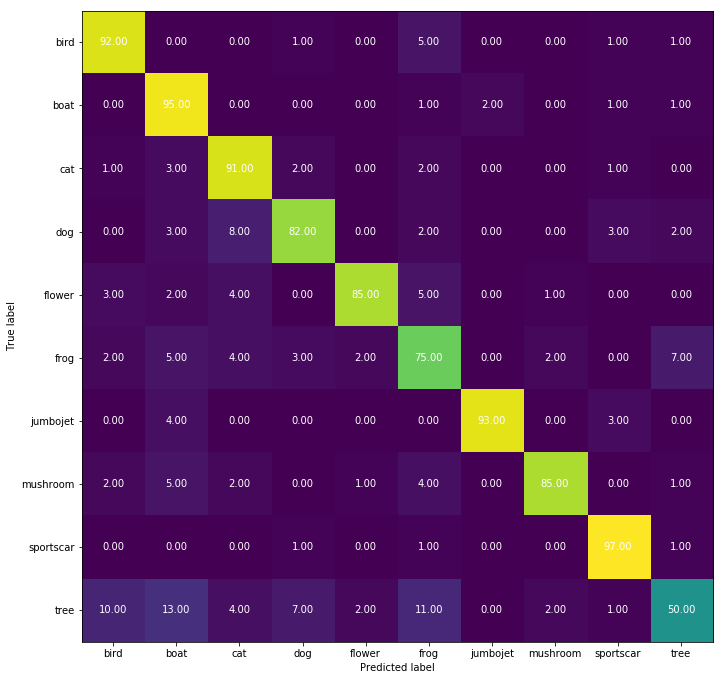

In [36]:
from sklearn.metrics import confusion_matrix
from tmle.visualizations import plot_confusion_matrix

cm_test = confusion_matrix(y_true=y_resnet50_test, y_pred=clf.predict(X_resnet50_test))
plot_confusion_matrix(cm_test)

The next step may be to create a `XGBoost` classifier on top of feature vectors obtained from `ResNet50`. Selecting `XGBoost` can help to create a better model because:

* its performance is strictly better than `sklearn`'s implementation of `SVM`. This will allow more experiments to be carried out and better parameters to be selected.
* it may be hypothesized that the hierarchical representation of features derived from the model can lead to better representation of objects, e.g. interactions between features related to different parts of an object.

In [37]:
EXPERIMENT_NAME = 'resnet50_xgb'

In [38]:
from xgboost import XGBClassifier

space = dict()
space['max_depth'] = hp.choice('max_depth', np.arange(2, 8, 1))
space['learning_rate'] = hp.uniform('learning_rate', 0.001, 0.1)
space['n_estimators'] = hp.choice('n_estimators', np.arange(50, 500, 50))
space['min_child_weight'] = hp.choice('min_child_weights', [1, 5, 25])
space['subsample'] = hp.uniform('subsample', 0.5, 1.)
space['colsample_bytree'] = hp.uniform('colsample_bytree', 0.2, 0.85)
space['colsample_bylevel'] = hp.uniform('colsample_bylevel', 0.2, 0.85)

In [39]:
%%skip $IMPATIENCE
clf_optim = ClassifierOptimizer(
    classifier=XGBClassifier(n_jobs=-1, random_state=42, verbose=1),
    space=space,
    metric=balanced_accuracy_score
)
clf_optim.find_best_params(
    X_resnet50,
    y_resnet50,
    experiments_path='../experiments/',
    experiments_name=EXPERIMENT_NAME,
    max_evals=1,
    overfit_penalty=0.1
)

# Finetuning ResNet18

In this part we have finetuned `ResNet18`. We have initialized a network with weights obtained on `ImageNet`.

## SGD

We have used `SGD` with a mini-batch size of 32. The learning rate starts from 0.001 and was manually decresed when the values of loss functions begin to oscillate or the performance on test set plateaus. First training strategy could be describe in the following steps:

* for first 5 epochs we have used `SGD` with learning rate set to `0.001`,
* for the 5 consecutive epochs we used `SGD` with learning rate set to `0.00001` and momentum set to `0.9`,
* for next 10 epochs we used `SGD` with very small learning rate (`0.000001`) and momentum set to `0.99`.

We have decided to update learning rate every 5 epochs in order to use interesting relationship between *early stopping* and $L_{2}$ regularization.

Below explanations comes from [here](https://www.deeplearningbook.org/contents/regularization.html):

<img src="figures/early_stopping.png" width=600>

An illustration of the effect of early stopping. (Left) The solid contour lines indicate the contours of the negative log-likelihood. The dashed line indicates the trajectory taken by SGD beginning from the origin. Rather than stopping at the point $w^{*}$ that minimizes the cost, early stopping results in the trajectory stopping at an earlier point $\hat{w}$. (Right) An illustration of the effect of $L^{2}$ regularization for comparison. The dashed circles indicate the contours of the $L^{2}$ penalty, which causes the minimum of the total cost to lie nearer the origin than the minimum of the unregularized cost.

We used [`TransferLearning`](https://github.com/stasulam/tmle/blob/master/tmle/models.py#L15) from `tmle` which helps us in managing training process. Models were saved (as a checkpoints) on `Google Drive`.

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tmle.models import TransferLearning

resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

In [41]:
model = resnet18
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001)

In [42]:
train_dataset = ImageFoldersDataset(
    path_to_data='../data/cpu/train/',
    transform=basic_transforms
)
test_dataset = ImageFoldersDataset(
    path_to_data='../data/cpu/test/',
    transform=basic_transforms
)

We have defined manager which saves best model and store information about metrics.

In [43]:
manager_first_stage = TransferLearning(
    experiments_path='../models/',
    experiments_name='resnet18'
)

Run training loop.

In [44]:
%%skip $IMPATIENCE
manager_first_stage.train(
     model=resnet18,
     criterion=criterion,
     optimizer=optimizer,
     train_dataset=train_dataset,
     test_dataset=valid_dataset,
     n_epochs=5,
     batch_size=32,
     shuffle=True
)

We saved results:

```
[1] train score: 0.650, test score: 0.751
[2] train score: 0.780, test score: 0.790
[3] train score: 0.802, test score: 0.740
[4] train score: 0.802, test score: 0.755
[5] train score: 0.880, test score: 0.780
CPU times: user 24min 52s, sys: 7min 52s, total: 32min 44s
Wall time: 1h 55min 28s
```

Then, we initialized the class of the model and modified the optimizer.

In [45]:
model = resnet18
optimizer = optim.SGD(
    model.parameters(),
    lr=0.00001,
    momentum=0.9
)

Load checkpoint from disk.

In [46]:
checkpoint = torch.load('../models/resnet18.pth', map_location='cpu')

Load states from checkpoint.

In [47]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Then, we defined training manager for second stage of training procedure.

In [48]:
manager_second_stage = TransferLearning(
    experiments_path='../models/',
    experiments_name='resnet18_5_10_epoch'
)

Run training loop.

In [49]:
%%skip $IMPATIENCE
manager_second_stage.train(
     model=model,
     criterion=criterion,
     optimizer=optimizer,
     train_dataset=train_dataset,
     test_dataset=valid_dataset,
     n_epochs=5,
     batch_size=32,
     shuffle=True
)

We saved results:
    
```
[1] train score: 0.802, test score: 0.755
[2] train score: 0.802, test score: 0.755
[3] train score: 0.880, test score: 0.780
[4] train score: 0.880, test score: 0.794
[5] train score: 0.880, test score: 0.844
CPU times: user 24min 2s, sys: 7min 42s, total: 31min 44s
Wall time: 35min 35s
```

Then, we initialized model and optimizer with different parameters.

In [50]:
model = resnet18
optimizer = optim.SGD(
    model.parameters(),
    lr=0.000001,
    momentum=0.99
)

Load checkpoint from disk.

In [51]:
checkpoint = torch.load('../models/resnet18_5_10_epoch.pth', map_location='cpu')

Load states from checkpoint.

In [52]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Then, we defined training manager for third stage of training procedure.

In [53]:
manager_third_stage = TransferLearning(
    experiments_path='../models/',
    experiments_name='resnet18_10_20_epoch'
)

Run training loop.

In [54]:
%%skip $IMPATIENCE
manager_third_stage.train(
     model=model,
     criterion=criterion,
     optimizer=optimizer,
     train_dataset=train_dataset,
     test_dataset=valid_dataset,
     n_epochs=10,
     batch_size=32,
     shuffle=True
)

We saved results:

```
[1] train score: 0.907, test score: 0.869
[2] train score: 0.907, test score: 0.869
[3] train score: 0.907, test score: 0.869
[4] train score: 0.907, test score: 0.869
[5] train score: 0.907, test score: 0.869
[6] train score: 0.907, test score: 0.894
[7] train score: 0.907, test score: 0.894
[8] train score: 0.907, test score: 0.894
[9] train score: 0.907, test score: 0.894
[10] train score: 0.963, test score: 0.894
CPU times: user 52min 26s, sys: 15min 57s, total: 1h 8min 23s
Wall time: 2h 11min 59s
```

In [55]:
checkpoint = torch.load('../models/resnet18_10_20_epoch.pth', map_location='cpu')
model = resnet18
model.load_state_dict(checkpoint['model_state_dict'])

## AdaBound

Authors claimed that: *[AdaBound is] An optimizer that trains as fast as Adam and as good as SGD, for developing state-of-the-art deep learning models on a wide variety of popular tasks in the field of CV, NLP, and etc*. Let's check.

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import adabound
from torchvision import transforms, models
from tmle.dataloaders import ImageFoldersDataset

resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

We have used default values of parameters provided by the authors.

In [57]:
model = resnet18
criterion = nn.CrossEntropyLoss()
optimizer = adabound.AdaBound(
    model.parameters(),
    lr=0.001,
    final_lr=0.1
)

Prepare images.

In [58]:
basic_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

train_dataset = ImageFoldersDataset(
    path_to_data='../data/cpu/train/',
    transform=basic_transforms
)
test_dataset = ImageFoldersDataset(
    path_to_data='../data/cpu/test/',
    transform=basic_transforms
)

Run training loop.

In [59]:
%%skip $IMPATIENCE
manager_first_stage = TransferLearning(
    experiments_path='../models/',
    experiments_name='resnet18_adabound'
)

manager_first_stage.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    n_epochs=10,
    batch_size=32,
    shuffle=True
)

We saved results:

```
[1] train score: 0.765, test score: 0.811
[2] train score: 0.907, test score: 0.830
[3] train score: 0.963, test score: 0.744
[4] train score: 0.907, test score: 0.844
[5] train score: 1.000, test score: 0.744
[6] train score: 0.963, test score: 0.830
[7] train score: 1.000, test score: 0.863
[8] train score: 0.963, test score: 0.819
[9] train score: 1.000, test score: 0.780
[10] train score: 1.000, test score: 0.863
```

We have observed that the optimizer was overshooting local minima. Possibly, parameters of the optimizer should be modified.